<a href="https://colab.research.google.com/github/GabrielKP/continual-learning/blob/main/cl_cifar10x10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basis

## Imports

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random
import math
import time
import copy
import itertools

### Load pretrained convLayers

For details look at pre_train_on_cifar10.ipynb

#### convLayers

In [2]:
class ConvLayers(nn.Module):
    """
    5 torch convolutional layers with batchnormalization
    and ReLU nonlinearity. No pooling is used. Inherits from nn.Module.
    Requires images with the same height and width.

    Methods
    -------
    forward(X) -> None
        Applies convolutions on input X

    Attributes
    ----------
    img_size : int
        number indicating the height of input images
    in_channels : int
        channels of input data
    out_channels : int
        amount of channels for last layer
    out_size : int
        height of the output data
    out_units : int
        total amount of units outputting
    """

    def __init__(self, in_channels, img_size):
        """
        Creates 5 conv layers with batchnorm and ReLU activation

        Parameters
        ----------
        in_channels : int
            Amount of channels the input data has
        img_size : int
            Amount of pixels in one axis
        """
        super(ConvLayers, self).__init__()

        list_out_channels = [16,32,64,128,256]

        self.img_size = img_size
        self.out_size = int(math.ceil(img_size / 2**4))
        self.in_channels = in_channels
        self.out_channels = list_out_channels[-1]
        self.out_units = self.out_channels * self.out_size**2
        
        self.conv1 = nn.Conv2d(in_channels, list_out_channels[0],
                               kernel_size=3, stride=1, bias=True, padding=1)
        self.bn1 = nn.BatchNorm2d(list_out_channels[0])
        self.nl1 = nn.ReLU()

        self.conv2 = nn.Conv2d(list_out_channels[0], list_out_channels[1],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn2 = nn.BatchNorm2d(list_out_channels[1])
        self.nl2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(list_out_channels[1], list_out_channels[2],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn3 = nn.BatchNorm2d(list_out_channels[2])
        self.nl3 = nn.ReLU()

        self.conv4 = nn.Conv2d(list_out_channels[2], list_out_channels[3],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn4 = nn.BatchNorm2d(list_out_channels[3])
        self.nl4 = nn.ReLU()

        self.conv5 = nn.Conv2d(list_out_channels[3], list_out_channels[4],
                               kernel_size=3, stride=2, bias=True, padding=1)
        self.bn5 = nn.BatchNorm2d(list_out_channels[4])
        self.nl5 = nn.ReLU()

    def forward(self, X):
        """
        Applies convolutions on input X
        """

        X1 = self.nl1(self.bn1(self.conv1(X)))
        X2 = self.nl2(self.bn2(self.conv2(X1)))
        X3 = self.nl3(self.bn3(self.conv3(X2)))
        X4 = self.nl4(self.bn4(self.conv4(X3)))
        X5 = self.nl5(self.bn5(self.conv5(X4)))

        return X5

#### Get pre-trained model from github and load it in

In [3]:
!wget -O convLayers_trained_cifar10.pt https://github.com/GabrielKP/continual-learning/blob/main/convLayers_trained_cifar10.pt?raw=true

--2021-09-06 21:13:59--  https://github.com/GabrielKP/continual-learning/blob/main/convLayers_trained_cifar10.pt?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/GabrielKP/continual-learning/raw/main/convLayers_trained_cifar10.pt [following]
--2021-09-06 21:13:59--  https://github.com/GabrielKP/continual-learning/raw/main/convLayers_trained_cifar10.pt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GabrielKP/continual-learning/main/convLayers_trained_cifar10.pt [following]
--2021-09-06 21:13:59--  https://raw.githubusercontent.com/GabrielKP/continual-learning/main/convLayers_trained_cifar10.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubu

In [4]:
convLayers = torch.load("convLayers_trained_cifar10.pt")

## Parameters

Main parameters are set here. They are fed later into the 'config' dic (see finetune>config) to prevent a global variable mess.

In [5]:
BATCH_SIZE = 64
N_TASKS = 10
N_EPOCHS_PER_TASK = 20
TEST_ALL_TASKS = 0 # Whether the network should be jointly trained on all tasks

N_EPOCHS_TOTAL = N_TASKS * N_EPOCHS_PER_TASK

CIFAR_INPUT_SIZE = 32 ** 2
CIFAR_N_CLASSES = 10

N_REPETITIONS = 3


# Model params
INPUT_DIM = CIFAR_INPUT_SIZE
HIDDEN1_DIM = 1000
HIDDEN2_DIM = 1000
OUTPUT_DIM = CIFAR_N_CLASSES
DROPOUT = 0.5

LEARNING_RATE = 0.001
BETAS = (0.9, 0.999)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

Most parameters are saved in the 'config' dictionary (see Fine-Tune for example). The config dictionary includes many running and static parameters and saves the chaos of having functions use global parameters or having indefinetely many different parameters for functions.

#### evaluate

In [6]:
def evaluate(model, dataloader, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for X, y in dataloader:
            #X = [batch_size, input_dim]
            #y = [batch_size]

            output = model(X)
            #output = [batch_size, n_classes]
            
            loss = criterion(output, y)

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

#### hitsLoss

In [7]:
def hitsLoss(outputs, labels):
    #outputs = [batch_size, n_classes]
    #labels = [batch_size]
    
    batch_size = outputs.shape[0]
    
    preds = outputs.detach().argmax(dim=-1)
    
    hits = sum(preds == labels)/batch_size
    
    return hits

#### evaluate_all_tasks

In [8]:
def evaluate_all_tasks(model, criterion, config, total_loss_array,
                       total_hits_array, idx, max_task=None):
    n_tasks_total = config["n_tasks_total"]
    dls_train = config["dls_train"]
    dls_test = config["dls_test"]
    if max_task is None or max_task > n_tasks_total:
        max_task = n_tasks_total

    for other_id in range(max_task):
        total_loss_array[other_id,0,idx] = evaluate(model,
                                                    dls_train[other_id],
                                                    criterion)
        total_loss_array[other_id,1,idx] = evaluate(model,
                                                    dls_test[other_id],
                                                    criterion)
        total_hits_array[other_id,0,idx] = evaluate(model,
                                                    dls_train[other_id],
                                                    hitsLoss)
        total_hits_array[other_id,1,idx] = evaluate(model,
                                                    dls_test[other_id],
                                                    hitsLoss)

#### create_schedule

In [9]:
def create_schedule(n_epochs_total, n_total_tasks, n_task_epochs):
    """Creates list of tuples: (task_id, n_task_epochs)"""
    # Creates a training schedule:
    schedule = []
    epoch_counter = n_epochs_total

    for task_id in itertools.cycle(range(n_total_tasks)):

        if epoch_counter - n_task_epochs <=0:
            schedule.append((task_id, epoch_counter))
            break
        else:
            schedule.append((task_id, n_task_epochs))
            epoch_counter -= n_task_epochs
    return schedule

def schedule_repetitions(x):
    """x amount of repetitions each task gets"""
    assert x != 0
    n_task_epochs = N_EPOCHS_TOTAL // ((N_TASKS + TEST_ALL_TASKS) * x)
    return create_schedule(N_EPOCHS_TOTAL, N_TASKS + TEST_ALL_TASKS, n_task_epochs)

#### schedules

A schedule specifies which task is trained for how many epochs in which order. The schedule is realized as list of tuples. The tuples have 2 components (task_id, n_task_epochs). The experiment is run by training the model on task_id for n_Task_epochs and then moving in order to the next tuple

In [10]:
not_interleaved = schedule_repetitions(1)
medium_interleaved = schedule_repetitions(4)
strong_interleaved = schedule_repetitions(8)
dbg_not_interleaved = create_schedule(100,10,10)
dbg_medium_interleaved = create_schedule(100,10,5)
dbg_strong_interleaved = create_schedule(100,10,2)

#### experiment

In [11]:
def experiment(
    config,
    init_func,
    repeat_func,
):
    """
    Runs experiment with a given task schedule and a model.
    The model, criterion and other specifics are defined through
    the init_func. The repeat_func is called in for every epoch.
    See finetune>training functions for examples

    Parameters
    ----------
    config : dict
        Contains all information and parameters for experiment.
    init_func : function() -> (model, criterion, pass_on_variables)
        Initializes the model and all its specifics. Returns 3 variables:
        (model, criterion, pass_on_variables). pass_on_variables are
        fed back into the repeat_func
    repeat_func : function(model, criterion, config, pass_on_variables) ->
                        (model, hist_loss, hist_hits)
        Is called every repetition. Here the model is trained for the amount of
        epochs according to the schedule. If eval_within is True, hist_loss,
        hist_hits are expected to be filled in with values, if
        not their values are ignored
    """
    schedule = config["schedule"]
    n_repetitions = config["n_repetitions"]
    n_datasets = config["n_datasets"]
    n_tasks_total = config["n_tasks_total"]
    eval_within = config["eval_within"]
    step_size_evaluation = config["step_size_evaluation"]
    experiment_name = config["experiment_name"]

    n_epochs_total = sum([x[1] for x in schedule])

    if eval_within:
        n_evaluations = sum([x[1] // step_size_evaluation for x in schedule])
        hist_all_losses = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_evaluations))
        hist_all_hitsss = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_evaluations))
    
    n_task_changes = len(schedule)
    
    hist_between_losses = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_task_changes))
    hist_between_hitsss = np.empty((n_repetitions, n_tasks_total, n_datasets,
                                    n_task_changes))

    config["curr_repetition"] = 0
    for repetition in range(n_repetitions):
        print(f"@@@@@@@@@ Repetition {repetition:3} @@@@@@@@@")
        if repetition == 0:
            models = []

        # Call task specific init function
        model, criterion, pass_on_variables = init_func(config)
        config["curr_sched_counter"] = 0
        n_evalsteps_passed = 0
        for i, (task_id, n_task_epochs) in enumerate(schedule):
            tag = f"{experiment_name}.s{i}.t{task_id}.e{n_task_epochs}"
            print(f"\nSCHEDULE: {tag}")

            # Call task specific repeat function
            config["curr_task_id"] = task_id
            config["curr_n_task_epochs"] = n_task_epochs
            model, hist_loss, hist_hits = repeat_func(model, criterion, config,
                                                      pass_on_variables)

            if eval_within:
                # Save performance history within tasks
                start_idx = n_evalsteps_passed
                end_idx = (n_evalsteps_passed + n_task_epochs //
                           step_size_evaluation)
                hist_all_losses[repetition,:,:,start_idx:end_idx] = hist_loss
                hist_all_hitsss[repetition,:,:,start_idx:end_idx] = hist_hits
                n_evalsteps_passed = end_idx
            
            # Evaluate Task performance after task
            evaluate_all_tasks(model,
                               criterion,
                               config,
                               hist_between_losses[repetition],
                               hist_between_hitsss[repetition],
                               i, 
                               i + 1)

            # Copy model to have at least one functional model in the end
            if repetition == 0 and model is not None:
                models.append(copy.deepcopy(model))

            config["curr_sched_counter"] += 1

        config["curr_repetition"] += 1

    if not eval_within:
        return hist_between_losses, hist_between_hitsss, None, None, models
    return (hist_between_losses, hist_between_hitsss, hist_all_losses,
            hist_all_hitsss, models)

#### epoch_time

In [12]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### filter_params

In [13]:
def filter_params(model, keywords):
    """Returns list of Parameters which include keyword"""
    ret = []
    if isinstance(keywords, list):
        for name, param in model.named_parameters():
            for keyword in keywords:
                if keyword in name:
                    ret.append(param)
        return ret
    else:
        for name, param in model.named_parameters():
            if keywords in name:
                ret.append(param)
        return ret

#### filter_params_inv

In [14]:
def filter_params_inv(model, keyword):
    """Returns list of Parameters which do not include keywords"""
    ret = []
    for name, param in model.named_parameters():
        if keyword not in name:
            ret.append(param)
    return ret

#### plot_accuracy_joint

In [15]:
def plot_accuracy_joint(hist_between_tasks, config, figsize=(10,7),
                        path=None):
    """
    Plots joint train and test accuracy on tasks network was trained on
    """
    schedule = config["schedule"]
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_between_tasks.shape
    assert n_task_switches == len(schedule)
    
    combined_error = np.empty((n_repetitions, n_datasets, n_task_switches))
    
    tasks_trained_on = set()
    # Get total accuracy for tasks already trained on
    for i, (task_id, _) in enumerate(schedule):
        tasks_trained_on.add(task_id)
        
        indices = list(tasks_trained_on)
        # Sum over tasks trained on
        s = np.sum(hist_between_tasks[:,indices,:,i], axis=0)

        # Divide by number of tasks
        d = s / len(tasks_trained_on)
        
        combined_error[:,:,i] = d
    
    # average runs
    hist_avg = np.average(combined_error, axis=0)
    # standard deviation
    hist_std = np.std(combined_error, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(combined_error)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(combined_error)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task switches")
    ax.set_ylabel("joint accuracy on past and current tasks")
    xvals = range(n_task_switches)
    
    for dataset_id in range(n_datasets):
        # Average
        ax.plot(xvals,
                hist_avg[dataset_id])
        # Stds
        ax.fill_between(xvals,
                       hist_min[dataset_id],
                       hist_max[dataset_id],
                       alpha=0.3)
    legends = np.array(["Train", "Test"])
    plt.legend(legends)
    plt.title(config["experiment_name"])
    plt.tight_layout()
    if path is not None:
        plt.savefig(path, dpi=300, bbox_inches='tight')

#### plot_accuracy_final

In [16]:
def plot_accuracy_final(hist_tasks, config, figsize=(10,7), dataset=1,
                        path=None):
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_tasks.shape
    
    # average runs
    hist_avg = np.average(hist_tasks, axis=0)
    # standard deviation
    hist_std = np.std(hist_tasks, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(hist_tasks)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(hist_tasks)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task")
    ax.set_ylabel("accuracy")
    xvals = range(n_task_switches)
    ax.set_xticks(xvals)
    ax.set_xticklabels(np.array(xvals) + 1)
    
    # Final Accuracy
    # Average
    ax.bar(xvals, hist_avg[:,dataset,-1])
    # Stds
    ax.fill_between(xvals,
                    hist_min[:,dataset,-1],
                    hist_max[:,dataset,-1],
                    alpha=0.3)

#### plot_accuracy_tasks

In [17]:
def plot_accuracy_tasks(hist_tasks, config, figsize=(10,7), dataset=1,
                        path=None):
    n_repetitions, n_tasks_total, n_datasets, n_task_switches = \
        hist_tasks.shape
    
    # average runs
    hist_avg = np.average(hist_tasks, axis=0)
    # standard deviation
    hist_std = np.std(hist_tasks, axis=0)
    # Make sure std does not show below min or above max
    minimal_val = np.min(hist_tasks)
    hist_min = np.fmax(hist_avg - hist_std, minimal_val)
    maximal_val = np.max(hist_tasks)
    hist_max = np.fmin(hist_avg + hist_std, maximal_val)

    width = 0.3
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    #ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("task")
    ax.set_ylabel("accuracy")
    xvals = np.arange(n_task_switches)
    ax.set_xticks(xvals)
    ax.set_xticklabels(xvals + 1)
    
    # Accuracy after training on specific task
    l1 = "Directly after Training on task"
    ax.bar(xvals - width, hist_avg[xvals,dataset,xvals], width,
           yerr=hist_std[xvals,dataset,xvals], label=l1)

    # Accuracy after training on next task
    l2 = "After training on next task"
    ax.bar(xvals[:-1], hist_avg[xvals[:-1],dataset,xvals[:-1] + 1], width,
           yerr=hist_std[xvals[:-1],dataset,xvals[:-1] + 1], label=l2)

    # Final Accuracy
    l3 = "After training on all tasks"
    ax.bar(xvals + width, hist_avg[:,dataset,-1], width,
           yerr=hist_std[:,dataset,-1], label=l3)

    plt.legend()
    plt.title(f'{["Train", "Test",][dataset]}: {config["experiment_name"]}')
    plt.tight_layout()

## Data

means and stds taken from 'pre_train_on_cifa10'

In [18]:
means = [0.491400808095932, 0.48215898871421814, 0.44653093814849854]
stds = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

### CIFAR10x10

In [49]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(means, stds)])

ds_train_cifar100 = datasets.CIFAR100("data", train=True,
                                      transform=transform,
                                      download=True)

ds_test_cifar100 = datasets.CIFAR100("data", train=False,
                                     transform=transform,
                                     download=False)

Files already downloaded and verified


Task labels (of no functional relevance)

In [50]:
labels_task1 = ["apples", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottles"]
labels_task2 = ["bowls", "boy", "bridge", "bus", "butterfly", "camel", "cans", "castle", "caterpillar", "cattle"]
labels_task3 = ["chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cups", "dinosaur"]
labels_task4 = ["dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "computer keyboard"]
labels_task5 = ["lamp", "lawn mower", "leopard", "lion", "lizard", "lobster", "man", "maple tree", "motor cycle", "mountain"]
labels_task6 = ["mouse", "mushrooms", "oak tree", "oranges", "orchids", "otter", "palm tree", "pears", "pickup truck", "pine tree"]
labels_task7 = ["plain", "plates", "poppies", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket"]
labels_task8 = ["roses", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider"]
labels_task9 = ["squirrel", "streetcar", "sunflowers", "sweet peppers", "table", "tank", "telephone", "television", "tiger", "tractor"]
labels_task10 = ["train", "trout", "tulips", "turtle", "wardrobe", "whale", "willow tree", "wolf", "woman", "worm"]
labels = [labels_task1, labels_task2, labels_task3, labels_task4, labels_task5, labels_task6, labels_task7, labels_task8, labels_task9, labels_task10]

In [51]:
idx_labels = [ [list(range(task_id*10, task_id*10 + 10))] for task_id in range(10)]

In [52]:
def concat(ilist):
    if len(ilist) == 2:
        return ilist[0] + ilist[1]
    return ilist[0] + concat(ilist[1:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


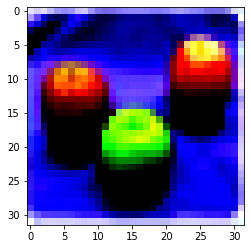

In [53]:
plt.imshow( ds_test_cifar100[9][0].permute(1, 2, 0))

### Group data into the right tasks

In [54]:
dss_train = [[] for _ in range(N_TASKS)]
for datapoint in ds_train_cifar100:
    task_id = datapoint[1] // 10
    dss_train[task_id].append((datapoint[0].to(DEVICE),
                               torch.tensor(datapoint[1] % 10).to(DEVICE)))

In [55]:
dss_test = [[] for _ in range(N_TASKS)]
for datapoint in ds_test_cifar100:
    task_id = datapoint[1] // 10
    dss_test[task_id].append((datapoint[0].to(DEVICE),
                              torch.tensor(datapoint[1] % 10).to(DEVICE)))

In [56]:
dls_train = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in dss_train]
dls_test = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False) for ds in dss_test]

# Fine-Tuning


### FineTune

In [57]:
class FineTune(nn.Module):

    def __init__(self, config):
        super(FineTune, self).__init__()

        self.convLayers = copy.deepcopy(config["convLayers"])
        self.hidden1_dim = config["hidden1_dim"]
        self.hidden2_dim = config["hidden2_dim"]
        self.output_dim = config["output_dim"]
        self.multi_head = config["multi_head"]
        self.lr = config["learning_rate"]
        self.betas = config["betas"]
        self.device = config["device"]

        self.convLayers.requires_grad_(False)

        self.fc1 = nn.Linear(self.convLayers.out_units, self.hidden1_dim)
        self.nl1 = nn.ReLU()

        self.fc2 = nn.Linear(self.hidden1_dim, self.hidden2_dim)
        self.nl2 = nn.ReLU()

        self.base_params = ["fc1", "fc2"]

        self.to(self.device)

        self.opts = []
        self.heads = 0
        self.new_head()

    def forward(self, X, head_id=0):
        """
        Applies convolutions and linear layers on input X
        """

        X1 = self.convLayers(X)
        X2 = self.nl1(self.fc1(torch.flatten(X1, start_dim=1)))
        X3 = self.nl2(self.fc2(X2))

        name = f"fc_out{head_id}"

        fc_out = self.get_submodule(name)

        return fc_out(X3)

    def new_head(self):
        """
        Appends new heads
        """
        name = f"fc_out{self.heads}"
        self.add_module(name, nn.Linear(self.hidden2_dim, self.output_dim).
                        to(self.device))
        
        # Choose right parameters for optimizer
        keywords = self.base_params + [name,]
        self.opts.append(optim.Adam(filter_params(self, keywords),
                                    lr=self.lr,
                                    betas=self.betas))
        self.heads += 1

    def task_update(self):
        """
        Creates new head if multihead
        """
        if self.multi_head:
            self.new_head()

## training functions

### train_finetune

In [58]:
def train_finetune(model, dataloader, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for X, y in dataloader:

        optimizer.zero_grad()

        output = model(X)

        loss = criterion(output, y)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

### fit_finetune

In [59]:
def fit_finetune(
    model,
    optimizer,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    task_id = config["curr_task_id"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #TODO: CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)
        
        start_time = time.time()
        
        train_loss = train_finetune(model, dls_train[task_id], optimizer, criterion, clip)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #TODO: CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        
        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if eval_within:
        return total_loss, total_hits
    return None, None

### repeat_func, init_func

In [60]:
def init_func_finetune(config):
    nmodel = FineTune(config)
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = dict()
    return nmodel, criterion, pass_on_variables

def repeat_func_finetune(model, criterion, config, pass_on_variables):
    optimizer = model.opts[0]
    fit_finetune(model, optimizer, criterion, config)
    
    return model, None, None

### config

In [61]:
"""
config: configuration dictionary for experiment.
Variables starting with 'curr' are changed within the experiment.

Parameters
----------
experiment_name : string
    Name for the experiment
n_repetitions : int
    Amount of repetitions the experiment has
n_tasks_total : int
    Amount of tasks in total (CIFAR10x10 has 10)
n_datasets : int
    Amount of datasets, is 2 if you only have train and test,
    but is 3 if you have train, valid and test.
device : torch.device
    gpu or cpu depending on what is available
schedule : list of tuples: [(task1, epochs1), (task2, epochs2), ...]
    Defines which task is trained on for how many tuples
clip : float
    clip for which gradients should be clipped during training, helps for more
    stable training and if gradients explode.
eval_within : Bool
    Switch whether performance is evaluated within a task or not
step_size_eval : int
    If eval_within, then this value determines after how many epochs within
    a repetition performance is evaluated.
learining_rate : float
    learning rate for optimizer
betas : tuple(float, float)
    betas for Adam Optimizer
dls_train : list[DataLoader1, DataLoader2,...]
    The Dataloader for the corresponding task_id at the index:
    Task1, idx=0, DataLoader1; Task2, idx=1, DataLoader2;...
dls_test : list[DataLoader1, DataLoader2,...]
    Same as dls_train but for test
hidden1_dim : int

hiddem2_dim : int

output_dim : int
    dimensionality of task output (CIFAR10x10 has 10, because 10 classes for
    each task)
"""

config = {
    "experiment_name": "finetune",
    "n_repetitions": 1,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "device": DEVICE,
    "schedule": dbg_not_interleaved,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "convLayers": convLayers,
    "hidden1_dim": 2000,
    "hidden2_dim": 2000,
    "output_dim": OUTPUT_DIM,
    "multi_head": True,
}

### experiment

In [62]:
hist_losses, hist_hitsss, _, _, models = experiment(config, init_func_finetune, repeat_func_finetune)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: finetune.s0.t0.e10
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 1.557 | Train PPL:   4.744
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 0.958 | Train PPL:   2.607
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 0.659 | Train PPL:   1.932
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.372 | Train PPL:   1.451
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.201 | Train PPL:   1.222
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.155 | Train PPL:   1.167
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss: 0.128 | Train PPL:   1.137
Epoch: 08 | Time: 0m 0s | R0 T0
	Train Loss: 0.113 | Train PPL:   1.120
Epoch: 09 | Time: 0m 0s | R0 T0
	Train Loss: 0.114 | Train PPL:   1.120
Epoch: 10 | Time: 0m 0s | R0 T0
	Train Loss: 0.083 | Train PPL:   1.086

SCHEDULE: finetune.s1.t1.e10
Epoch: 01 | Time: 0m 0s | R0 T1
	Train Loss: 2.148 | Train PPL:   8.568
Epoch: 02 | Time: 0m 0s | R0 T1
	Train Loss: 1.099 | Train PPL:   3.001
Epoch: 03 | Time: 0m 0s | R0 T1
	Train Lo

### results

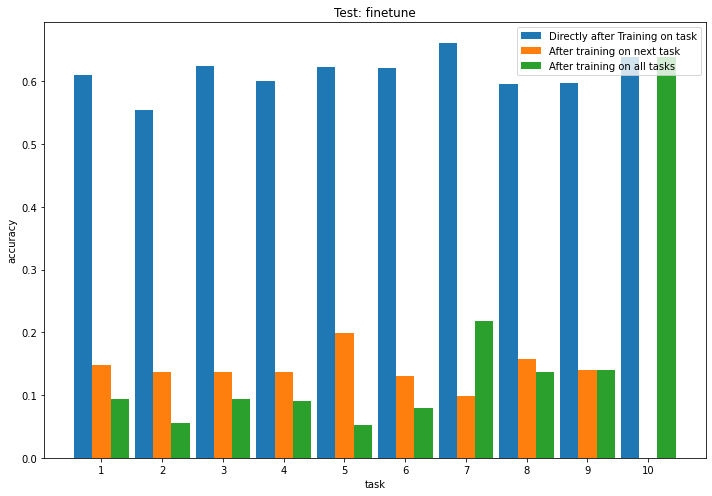

In [63]:
## TESTSET
plot_accuracy_tasks(hist_hitsss, config)

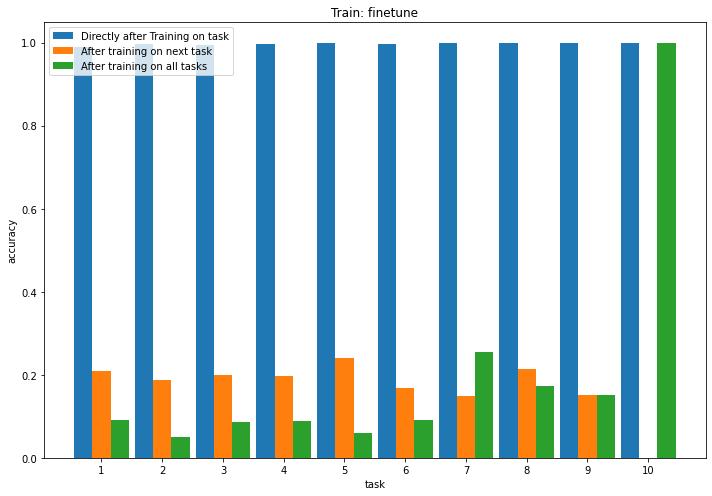

In [64]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss, config, dataset=0)

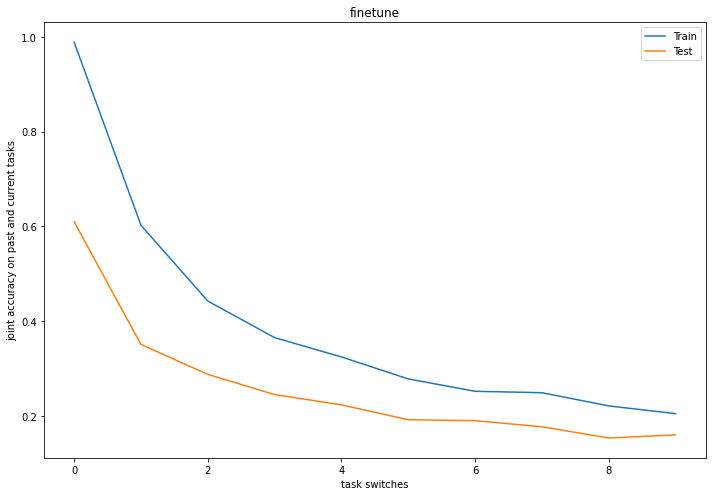

In [65]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss, config)

# EWC

### EWC (class)

In [67]:
class EWC(nn.Module):

    def __init__(self, convLayers, hidden1_dim, hidden2_dim, output_dim,
                 ewc_lambda):
        super(EWC, self).__init__()

        self.convLayers = convLayers
        self.hidden_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(convLayers.out_units, hidden1_dim)
        self.nl1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.nl2 = nn.ReLU()

        self.fc_out = nn.Linear(hidden2_dim, output_dim)

        # EWC specifics
        self.fishers = []
        self.opt_params = []
        self.ewc_lambda = ewc_lambda

    def forward(self, X):
        """
        Applies convolutions on input X
        """

        X1 = self.convLayers(X)
        X2 = self.nl1(self.fc1(torch.flatten(X1, start_dim=1)))
        X3 = self.nl2(self.fc2(X2))

        return self.fc_out(X3)

    def task_update(self, dataloader, opt, crit):
        
        self.train()
        opt.zero_grad()

        # Accumulate Gradient to obtain fisher
        for X, y in dataloader:

            out = self(X)

            loss = crit(out, y)

            loss.backward()

        # Save fisher and optimal parameters
        self.fishers.append({})
        self.opt_params.append({})

        for name, param in self.named_parameters():
            self.fishers[-1][name] = param.grad.data.clone().pow(2)
            self.opt_params[-1][name] = param.data.clone()

    def ewc_loss(self):
        loss = 0
        for i in range(len(self.fishers)):
            for name, param in self.named_parameters():
                fisher = self.fishers[i][name]
                opt_param = self.opt_params[i][name]
                loss += ((fisher * (opt_param - param).pow(2)).sum()*
                         self.ewc_lambda)
        return loss

## training functions

#### train_ewc

In [59]:
def train_ewc(model, dataloader, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for X, y in dataloader:

        optimizer.zero_grad()

        output = model(X)

        loss = criterion(output, y)

        loss += model.ewc_loss()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

#### fit_ewc

In [58]:
def fit_ewc(
    model,
    optimizer,
    criterion,
    config
):
    repetition = config["curr_repetition"]
    n_task_epochs = config["curr_n_task_epochs"]
    clip = config["clip"]
    eval_within = config["eval_within"]
    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]

    if eval_within:
        n_tasks_total = config["n_tasks_total"]
        n_datasets = config["n_datasets"]
        step_size_evaluation = config["step_size_evaluation"]
        total_hits = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        total_loss = torch.zeros((n_tasks_total, n_datasets,
                                n_task_epochs//step_size_evaluation,))
        # [task_id, dataset, evaluations]

    for epoch in range(n_task_epochs):
        # First Epoch log performance BEFORE training
        if epoch == 0 and eval_within:
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, 0, criterion)
        
        start_time = time.time()
        
        train_loss = train_ewc(model, dls_train[task_id], optimizer, criterion, clip)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Log performance AFTER training
        if eval_within and epoch % step_size_evaluation == 0 and epoch != 0:
            idx = epoch//step_size_evaluation
            #CHANGE
            eval_all_tasks(model, total_loss, total_hits, n_tasks_total, idx, criterion)

        
        if repetition is not None:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | R{repetition} T{task_id}')
        else:
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | T{task_id}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if eval_within:
        return total_loss, total_hits
    return None, None

#### repeat_func, init_func

In [57]:
def init_func_ewc(config):
    cL = copy.deepcopy(config["convLayers"])
    nmodel = EWC(cL, 2000, 2000, config["output_dim"], config["ewc_lambda"])
    criterion = nn.CrossEntropyLoss()

    pass_on_variables = dict()
    pass_on_variables["opt"] = optim.Adam(filter_params_inv(nmodel, "convLayer"),
                                          lr=config["learning_rate"],
                                          betas=config["betas"])
    return nmodel, criterion, pass_on_variables

def repeat_func_ewc(model, criterion, config, pass_on_variables):

    optimizer = pass_on_variables["opt"]

    fit_ewc(model, optimizer, criterion, config)

    dls_train = config["dls_train"]
    task_id = config["curr_task_id"]
    model.task_update(dls_train[task_id], optimizer, criterion)
    
    return model, None, None

#### config_ewc

In [91]:
"""
New Parameters
--------------
ewc_lambda : int
    EWC parameter determining how big the influence of the old parameters
    should be compared to the adaption to the newly trained task
    (Balancing old task performance with new task performance)
"""

config_ewc = {
    "experiment_name": "ewc",
    "n_repetitions": 1,
    "n_tasks_total": N_TASKS,
    "n_datasets": 2,
    "schedule": dbg_not_interleaved,
    "clip": 1,
    "eval_within": False,
    "step_size_evaluation": 10,
    "output_dim": OUTPUT_DIM,
    "learning_rate": LEARNING_RATE,
    "betas": BETAS,
    "dls_train": dls_train,
    "dls_test": dls_test,
    "convLayers": convLayers,
    "ewc_lambda": 5,
}

### experiment

In [92]:
hist_losses_ewc, hist_hitsss_ewc, _, _, models = \
    experiment(config_ewc, init_func_ewc, repeat_func_ewc)

@@@@@@@@@ Repetition   0 @@@@@@@@@

SCHEDULE: ewc.s0.t0.e10
Epoch: 01 | Time: 0m 0s | R0 T0
	Train Loss: 2.528 | Train PPL:  12.527
Epoch: 02 | Time: 0m 0s | R0 T0
	Train Loss: 1.926 | Train PPL:   6.864
Epoch: 03 | Time: 0m 0s | R0 T0
	Train Loss: 1.192 | Train PPL:   3.295
Epoch: 04 | Time: 0m 0s | R0 T0
	Train Loss: 0.608 | Train PPL:   1.837
Epoch: 05 | Time: 0m 0s | R0 T0
	Train Loss: 0.347 | Train PPL:   1.414
Epoch: 06 | Time: 0m 0s | R0 T0
	Train Loss: 0.129 | Train PPL:   1.137
Epoch: 07 | Time: 0m 0s | R0 T0
	Train Loss: 0.038 | Train PPL:   1.039
Epoch: 08 | Time: 0m 0s | R0 T0
	Train Loss: 0.017 | Train PPL:   1.017
Epoch: 09 | Time: 0m 0s | R0 T0
	Train Loss: 0.006 | Train PPL:   1.006
Epoch: 10 | Time: 0m 0s | R0 T0
	Train Loss: 0.009 | Train PPL:   1.009

SCHEDULE: ewc.s1.t1.e10
Epoch: 01 | Time: 0m 0s | R0 T1
	Train Loss: 6.151 | Train PPL: 469.297
Epoch: 02 | Time: 0m 0s | R0 T1
	Train Loss: 4.056 | Train PPL:  57.745
Epoch: 03 | Time: 0m 0s | R0 T1
	Train Loss: 1.887 

### results

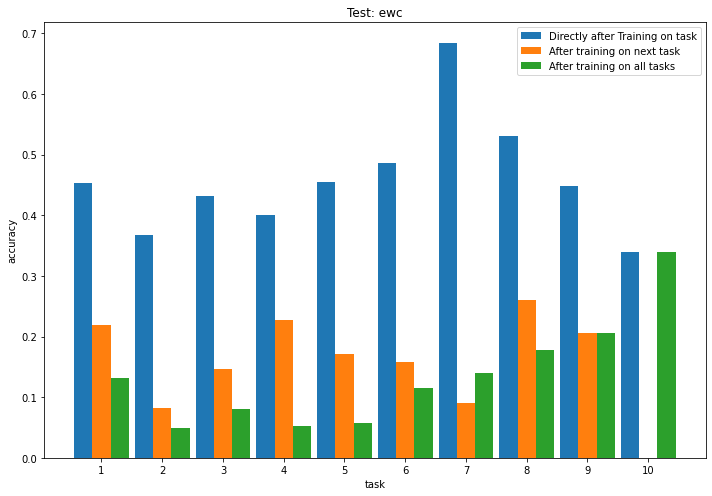

In [93]:
## TESTSET
plot_accuracy_tasks(hist_hitsss_ewc, config_ewc)

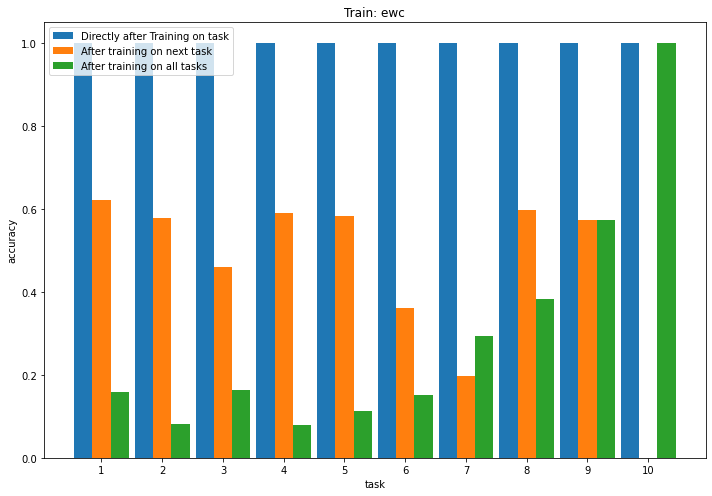

In [94]:
## TRAINSET
plot_accuracy_tasks(hist_hitsss_ewc, config_ewc, dataset=0)

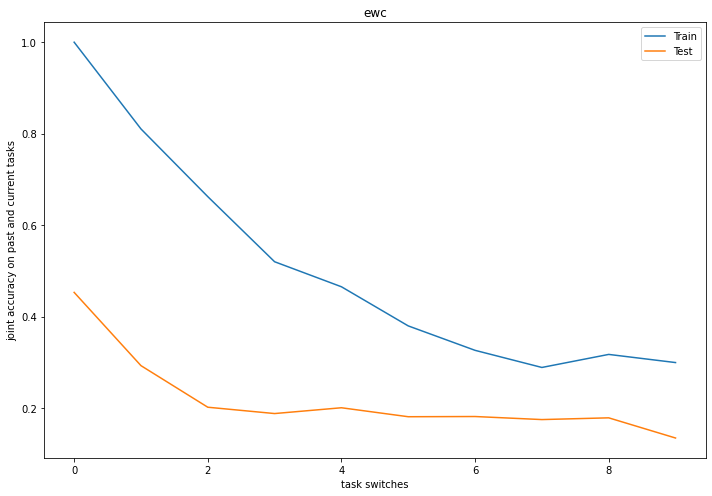

In [95]:
## Accuracy on trained tasks together
plot_accuracy_joint(hist_hitsss_ewc, config_ewc)

# SI

# DynaMoE (?)

### Gating (Class)

In [ ]:
class Gating(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_max_experts, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_max_experts = n_max_experts

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.nl1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(hidden_dim, n_max_experts)

    def forward(self, X):

        X1 = self.dropout(self.nl1(self.fc1(X)))

        return self.fc_out(X1)

# Ensembling